**Course 6 - Neural Networks**

**Assignment in Neural Network - CNN based model which can detect melanoma**

**Name - Arnav Munshi(UOA MS DS Cohort-3)**

Problem Statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [24]:
#Part 1 : take necessary actions to read the data
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
import pathlib

In [17]:
!pip install --upgrade tensorflow

In [18]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

In [19]:
from google.colab import drive #using the data mounted on google colab

In [20]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
%ls

CNN_assignment.zip  gdrive/  kaggle.json  sample_data/


In [22]:
#defining the path for train and test images
root_path='/content/gdrive/MyDrive/CNN/Skin_cancer_datastore'


In [25]:
data_train=pathlib.Path(root_path + '/Train')
data_test=pathlib.Path(root_path + '/Test')

In [26]:
image_count_train = len(list(data_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [27]:
#Create the dataset
#define the parameters on the loader:

batch_size=32
img_height=180
img_width=180

#80% of the images to be used for training and %20 used for validation

In [28]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_df=tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [29]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_df=tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [30]:
#writing the test dataset here
test_df=tf.keras.preprocessing.image_dataset_from_directory(
    data_test,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [31]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_df.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Data Visualization**

code to visualize one instance of all the nine classes present in the dataset

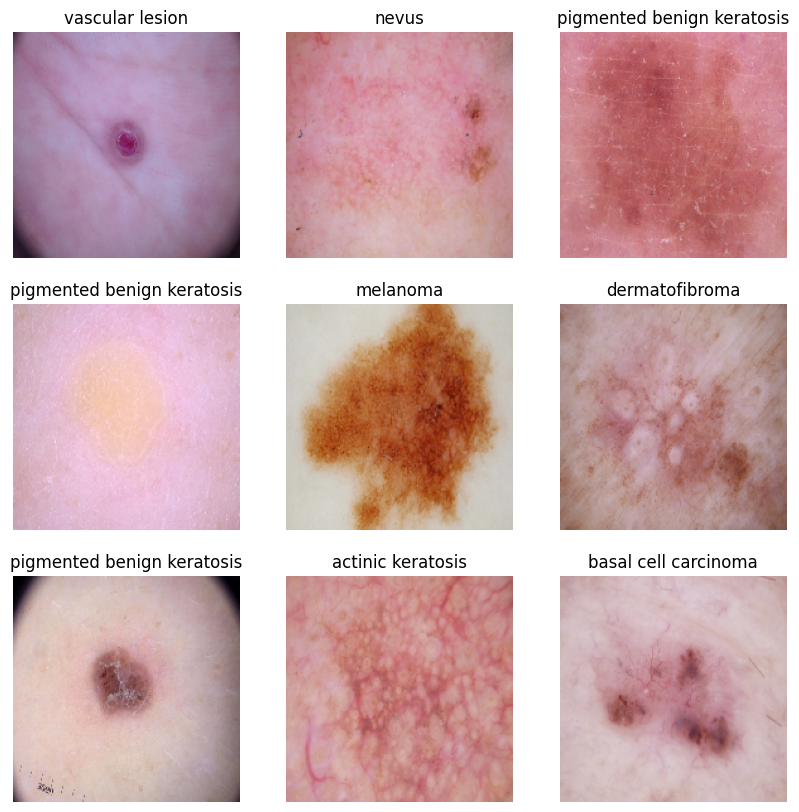

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_df.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_df = val_df.cache().prefetch(buffer_size=AUTOTUNE)

**Creating the Model**

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [34]:
preprocessing_layers=[
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))
]

In [35]:
#main code starts here for the model
input_shape=(180,180,3)
lr=1e-5
init='normal'
activ='relu'

model=Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(input_shape)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 86, 86, 64)        256       
 chNormalization)                                     

In [36]:
#compiling the model
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [37]:
#viewing the model of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 86, 86, 64)        256       
 chNormalization)                                     

In [38]:
#Training the model
epochs = 20
batch_size = 32

history = model.fit(train_df,
  batch_size=batch_size,
  validation_data=val_df,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 216s 879ms/step - loss: -72466.4531 - accuracy: 0.1719 - val_loss: -71202.6016 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: -819764.6875 - accuracy: 0.1724 - val_loss: -739417.0625 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 4s 66ms/step - loss: -3112455.5000 - accuracy: 0.1724 - val_loss: -3067188.0000 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: -7695183.0000 - accuracy: 0.1724 - val_loss: -6997220.5000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 4s 64ms/step - loss: -15347289.0000 - accuracy: 0.1724 - val_loss: -13727786.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 4s 65ms/step - loss: -26586366.0000 - accuracy: 0.1724 - val_loss: -29423716.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 4s 66ms/step - lo

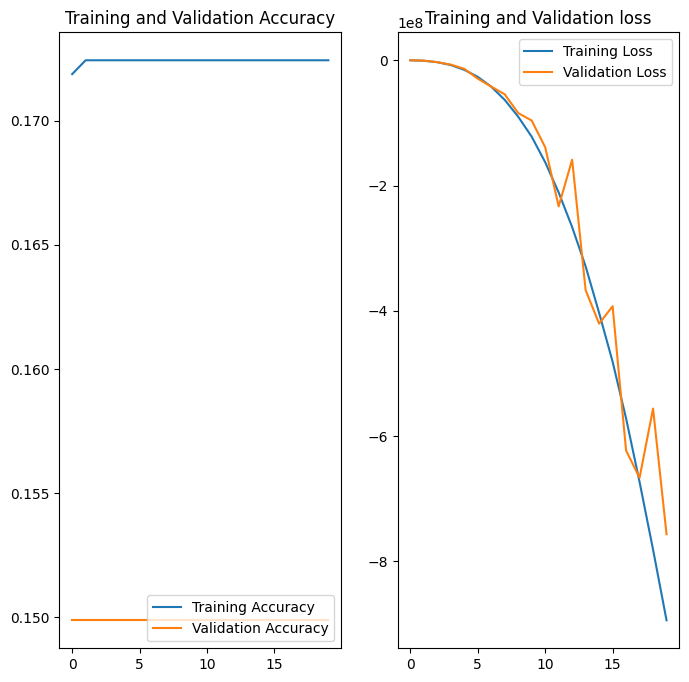

In [39]:
#Visualizing Training Results
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

In [40]:
#Checking if the model is underfit or overfit
loss,accuracy=model.evaluate(train_df,verbose=1)
loss_v,accuracy_v=model.evaluate(train_df,verbose=1)

56/56 [==============================] - 1s 17ms/step - loss: -743857664.0000 - accuracy: 0.1724


In [41]:
print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

Accuracy:  0.1724330335855484
Validation Accuracy:  0.1724330335855484
Loss:  -743857664.0
Validation Loss -743857664.0


In [43]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches=datagen.flow_from_directory(data_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


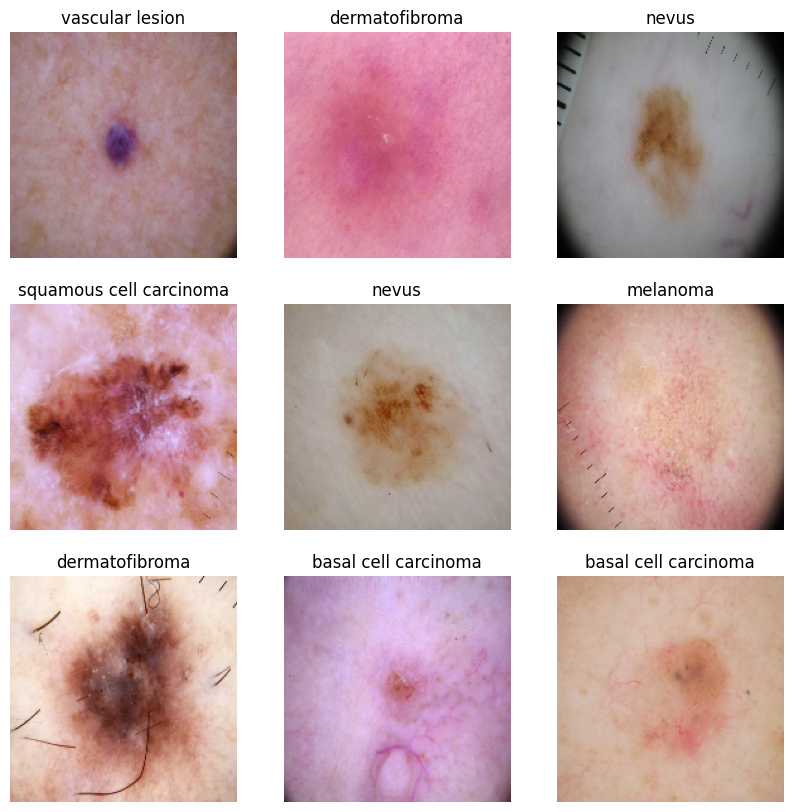

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [45]:
#Create , compile and training the model
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)        36928     
                                                      

In [48]:
#compiling the model
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=None,decay=0.0,amsgrad=False)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [49]:
#set a learning rate annealer
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy',
                                          patience=3,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr=0.00001)

In [51]:
#Training then model for 30 epochs
epochs=20
batch_size=10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 58s 4s/step - loss: 0.6201 - accuracy: 0.7067 - val_loss: 1.7374 - val_accuracy: 0.5833 - lr: 6.2500e-05
Epoch 2/20
14/14 [==============================] - 47s 3s/step - loss: 0.6181 - accuracy: 0.7101 - val_loss: 1.7604 - val_accuracy: 0.6042 - lr: 6.2500e-05
Epoch 3/20
14/14 [==============================] - 46s 3s/step - loss: 0.6079 - accuracy: 0.7056 - val_loss: 1.7030 - val_accuracy: 0.5625 - lr: 6.2500e-05
Epoch 4/20
14/14 [==============================] - 50s 4s/step - loss: 0.6232 - accuracy: 0.7101 - val_loss: 1.7680 - val_accuracy: 0.6042 - lr: 6.2500e-05
Epoch 5/20
14/14 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.7213
Epoch 5: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
14/14 [==============================] - 49s 4s/step - loss: 0.6223 - accuracy: 0.7213 - val_loss: 1.7627 - val_accuracy: 0.4583 - lr: 6.2500e-05
Epoch 6/20
14/14 [==============================] - 49s 

In [52]:
!pip install Augmentor

In [54]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/"
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6AE448EDA0>: 100%|██████████| 500/500 [00:28<00:00, 17.52 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6AE42AB280>: 100%|██████████| 500/500 [00:25<00:00, 19.58 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6B10C23820>: 100%|██████████| 500/500 [00:29<00:00, 17.07 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6AE4424640>: 100%|██████████| 500/500 [02:14<00:00,  3.72 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2117x1988 at 0x7F6AE44272E0>: 100%|██████████| 500/500 [01:47<00:00,  4.64 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6B10C236D0>: 100%|██████████| 500/500 [00:29<00:00, 17.20 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F6AE44C4880>: 100%|██████████| 500/500 [01:04<00:00,  7.74 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6B0C0AB5B0>: 100%|██████████| 500/500 [00:25<00:00, 19.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6AE4105B10>: 100%|██████████| 500/500 [00:29<00:00, 17.24 Samples/s]


In [55]:
image_count_train=len(list(data_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [58]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_421e93f2-1add-4ddb-ac94-04c4460fca36.jpg',
 '/content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_995bffa9-a020-436e-9dd7-81070393a4e9.jpg',
 '/content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_3e9f93f1-c7d3-4dd1-9a23-a61c197452d1.jpg',
 '/content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031381.jpg_bc3a9a5f-58a0-4576-818a-6e6cb56e3965.jpg',
 '/content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_3685a9d5-01e4-4504-a87a-985120966c89.jpg',
 '/content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_1d2ea41f-9a39-445c-bf9b

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [61]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [62]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df=df2

In [63]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [64]:
#Train the model on the data using Augmentor
batch_size=32
img_height=180
img_width=180

In [66]:
data_train="/content/gdrive/MyDrive/CNN/Skin_cancer_datastore/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [67]:
#Creating a vlaidation dataset
val_df = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [68]:
#Creating the model including normalization
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 90, 90, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 64)       

In [71]:
#Compiling the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [72]:
epochs = 50

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_df,
  epochs = epochs, verbose = 1, validation_data=val_df , callbacks=[learning_rate_reduction])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 17s 240ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 2/50
56/56 [==============================] - 15s 267ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 3/50
56/56 [==============================] - 15s 271ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 4/50
56/56 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1724
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 [==============================] - 16s 286ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 5/50
56/56 [==============================] - 17s 298ms/step - loss: 0.0000e+00 - accuracy: 0.1724 - val_loss: 0.0000e+00 - val_accuracy: 0.1151 - lr: 5.0000e-04
Epoch 6/50
56/56 [======

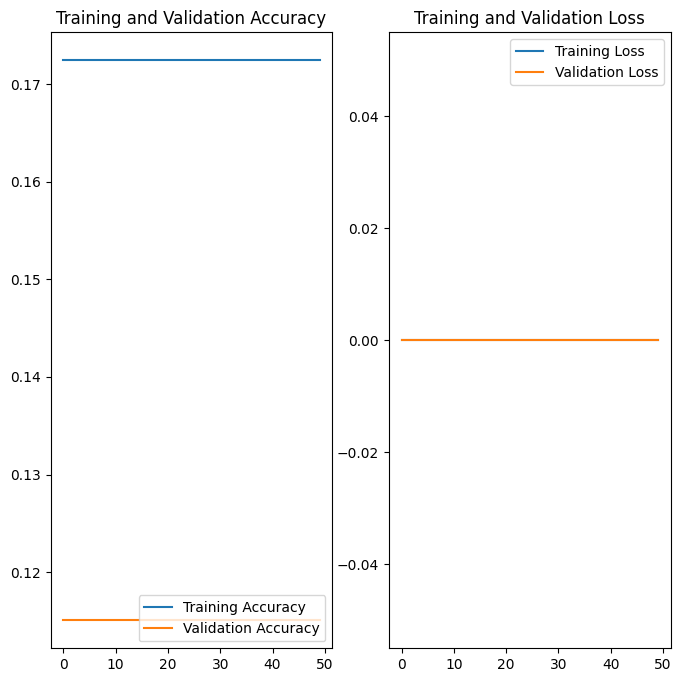

In [73]:
#Visualizing the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

How overfit and underfit was prevented and also has the class rebalance helped or not ?

Answer - The class rebalance had helped in reducing the overfitting and the loss also get low but it had impacted the accuracy.

But we had tried Batch Normalization and Augmentation which had supported in forward.

**End of the Notebook**